### Imports & Inputs

In [121]:
# Current 09-Jul-2023

In [122]:
import re
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options as FirefoxOptions

In [123]:
# Inputs. Insert coordinates of your desired neighbourhoods
central_frederic_coords = [43.450936, -80.481639] # Latitude, longitude
belmont_village_coords = [43.453351, -80.517898] # Latitude, longitude
vincienzos_coords = [43.459222, -80.519409]# Latitude, longitude

max_price = 1_000_000 # Max price to be plotted and considered. For no ceiling, = np.inf

### Retrieving Data

In [124]:
# Using Selenium to launch a headless Firefox session and retrieve the page source
options = FirefoxOptions()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get("https://www.redfin.ca/on/waterloo/filter/mr=33:2996,walk-score=70")

text_only = driver.find_element(By.TAG_NAME, "body").text

src1 = driver.page_source

In [125]:
# Write the page source to a local .txt file
from pathlib import Path

path = Path('data\houses.txt')

with path.open(mode='w', encoding='utf-8') as file:
    file.write(src1)

In [126]:
# Split the page text into a list, one element per house which matches the filters
# First item for each house is "mlsId". Split using this term
if type(src1) == type('str'):
    src1 = src1.split('mlsId')
    tail_end = src1[-1].split('isViewedListing')
    src1[-1] = tail_end[0]
len(src1)

170

In [127]:
# Create a list for each desired feature of each house
prices = []
addresses = []
property_types = []
square_footages = []
prices_per_sqft = []
n_beds = []
n_baths = []
cities = []
zip_codes = []
times_on_redfin = []
latitudes = []
longitudes = []

walk_scores = []

def add_value(feature, feature_list):
    if feature:
        feature_list.append(feature.group(1))
    else:
        feature_list.append(np.nan)

for house_data in src1[1:]:
    price = re.search(r'\\\"price\\\":{\\\"value\\\":(\d*)', house_data)
    add_value(price, prices)
    #prices = np.array(prices).astype(int)

    address = re.search(r'\\\"streetLine\\\":{\\\"value\\\":\\\"(.*?)\\\",', house_data)
    add_value(address, addresses)
    #addresses = np.array(addresses).astype(str)

    property_type = re.search(r'\\\"propertyType\\\":(\d*)', house_data) # Use dict to convert to sensible categories
    add_value(property_type, property_types)
    #property_types = np.array(property_types).astype(int)

    square_footage = re.search(r'\\\"sqFt\\\":{\\\"value\\\":(\d+),', house_data)
    add_value(square_footage, square_footages)
    #square_footage = np.array(square_footage).astype(int)

    price_per_sqft = re.search(r'\\\"pricePerSqFt\\\":{\\\"value\\\":(\d*?),', house_data)
    add_value(price_per_sqft, prices_per_sqft)
    #price_per_sqft = np.array(price_per_sqft).astype(int)

    n_bed = re.search(r'\\\"beds\\\":(\d*?),', house_data)
    add_value(n_bed, n_beds)
    #n_beds = np.array(n_beds).astype(int)

    n_bath = re.search(r'\\\"baths\\\":(\d+.\d*),', house_data)
    add_value(n_bath, n_baths)
    #n_baths = np.array(n_baths).astype(int)

    city = re.search(r'\\\"city\\\":\\\"(\D*?)\\\"', house_data)
    add_value(city, cities)
    #city = np.array(city).astype(str)

    zip_code = re.search(r'\\\"zip\\\":\\\"(\w\w\w \w\w\w)\\\"', house_data)
    add_value(zip_code, zip_codes)
    #zip_code = np.array(zip_code).astype(str)

    time_on_redfin = re.search(r'\\\"timeOnRedfin\\\":{\\\"value\\\":(\d+)', house_data)
    add_value(time_on_redfin, times_on_redfin)

    latitude = re.search(r'\\\"latLong\\\":{\\\"value\\\":{\\\"latitude\\\":(\d+.\d+),\\\"longitude\\\":-\d+.\d+}', house_data)
    longitude = re.search(r'\\\"latLong\\\":{\\\"value\\\":{\\\"latitude\\\":\d+.\d+,\\\"longitude\\\":(-\d+.\d+)}', house_data)
    add_value(latitude, latitudes)
    add_value(longitude, longitudes)

    # walk scores not listed in source text???

In [128]:
# For troubleshooting. Ensure that all feature lists have equal length
print(f'Num prices: {len(prices)}')
print(f'Num addresses: {len(addresses)}')
print(f'Num property types: {len(property_types)}')
print(f'Num sq footage: {len(square_footages)}')
print(f'Num price per sqft: {len(prices_per_sqft)}')
print(f'Num n_beds: {len(n_beds)}')
print(f'Num n_baths: {len(n_baths)}')
print(f'Num city: {len(cities)}')
print(f'Num zip code: {len(zip_codes)}')
print(f'Num uptime: {len(times_on_redfin)}')
print(f'Num latitudes: {len(latitudes)}')
print(f'Num longitudes: {len(longitudes)}')

Num prices: 169
Num addresses: 169
Num property types: 169
Num sq footage: 169
Num price per sqft: 169
Num n_beds: 169
Num n_baths: 169
Num city: 169
Num zip code: 169
Num uptime: 169
Num latitudes: 169
Num longitudes: 169


### Data Munging

In [129]:
# Create dataframe and take care of dtypes
df = pd.DataFrame({'address': addresses,
                    'unit_type': property_types,
                    'price': prices,
                    'sqft': square_footages,
                    'price_per_sqft': prices_per_sqft,
                    'n_beds': n_beds,
                    'n_baths': n_baths,
                    'city': cities,
                    'postal_code': zip_codes,
                    'days_on_redfin': times_on_redfin,
                    'latitude': latitudes,
                    'longitude': longitudes})

df.unit_type = pd.to_numeric(df.unit_type)
df.price = pd.to_numeric(df.price)
df.sqft = pd.to_numeric(df.sqft)
df.price_per_sqft = pd.to_numeric(df.price_per_sqft)
df.n_beds = pd.to_numeric(df.n_beds)
df.n_baths = pd.to_numeric(df.n_baths)
df.days_on_redfin = pd.to_numeric(df.days_on_redfin)
df.latitude = pd.to_numeric(df.latitude)
df.longitude = pd.to_numeric(df.longitude)

df.days_on_redfin = df.days_on_redfin / 1000 / 3600 / 24

In [130]:
# Calculating distances to user's desired neighbourhoods
import geopy.distance

df['km_to_Frederic'] = df.apply(lambda x: geopy.distance.geodesic([x.latitude, x.longitude], central_frederic_coords).km, axis=1)
df['km_to_Belmont'] = df.apply(lambda x: geopy.distance.geodesic([x.latitude, x.longitude], belmont_village_coords).km, axis=1)
df['km_to_Vincenzos'] = df.apply(lambda x: geopy.distance.geodesic([x.latitude, x.longitude], vincienzos_coords).km, axis=1)

df['closest_neighbourhood'] = df[['km_to_Frederic', 'km_to_Belmont', 'km_to_Vincenzos']].min(axis=1)
df = df.drop(['latitude', 'longitude'], axis=1) # Not useful once distances are calculated

In [131]:
# Dropping duplicate addresses
df = df.drop_duplicates(subset=['address'], keep='first') # Lots of duplicate listings for some reason

# Rounding off numbers for a cleaner look
df.days_on_redfin = df.days_on_redfin.round(1)
df.km_to_Frederic = df.km_to_Frederic.round(2)
df.km_to_Belmont = df.km_to_Belmont.round(2)
df.km_to_Vincenzos = df.km_to_Vincenzos.round(2)
df.closest_neighbourhood = df.closest_neighbourhood.round(2)

In [132]:
# Change the unit types from the default to human understandable language
unit_types = {3: 'Apartment', 4: 'Townhouse', 5: 'Townhouse', 6: 'Detached', 8: 'Vacant Land', 13: 'Condo Townhouse'} # Not 100% correct. Some apartments are listed as type 6, not sure why
df.unit_type = df.unit_type.replace(unit_types)
df.unit_type.unique()

array(['Apartment', 'Townhouse', 'Detached', 'Condo Townhouse', 11,
       'Vacant Land'], dtype=object)

### Search Statistics

In [133]:
df_lowPrice = df[df.price < max_price].reset_index(drop=True) 

In [134]:
# Numerical summary
df.describe() # Price of 5e05 is 500k

,price,sqft,price_per_sqft,n_beds,n_baths,days_on_redfin,km_to_Frederic,km_to_Belmont,km_to_Vincenzos,closest_neighbourhood
count,1.690000e+02,69.000000,69.000000,161.000000,160.00000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,7.374269e+05,1123.072464,647.956522,2.198758,1.64375,33.565680,2.979527,2.681953,2.463964,1.512308
std,1.235822e+06,644.210354,226.403884,1.482481,0.81145,30.873966,1.933125,0.931319,1.065388,0.783683
min,3.000000e+04,327.000000,250.000000,0.000000,1.00000,0.500000,0.180000,0.780000,0.140000,0.140000
25%,4.650000e+05,700.000000,468.000000,1.000000,1.00000,9.900000,0.860000,2.160000,2.050000,0.790000
50%,5.390000e+05,985.000000,670.000000,2.000000,1.50000,23.900000,3.720000,2.690000,2.240000,1.450000
75%,6.680000e+05,1350.000000,772.000000,3.000000,2.00000,51.700000,4.930000,2.880000,2.490000,2.180000
max,1.499900e+07,4481.000000,1500.000000,10.000000,6.00000,171.700000,5.340000,6.500000,6.590000,3.650000


In [135]:
# Categorical summary
df.describe(include='object')

,address,unit_type,city,postal_code
count,169,169,169,169
unique,169,6,2,87
top,251 Hemlock St #105,Apartment,Waterloo,N2L 3R2
freq,1,129,90,11


Text(0, 0.5, 'Count')

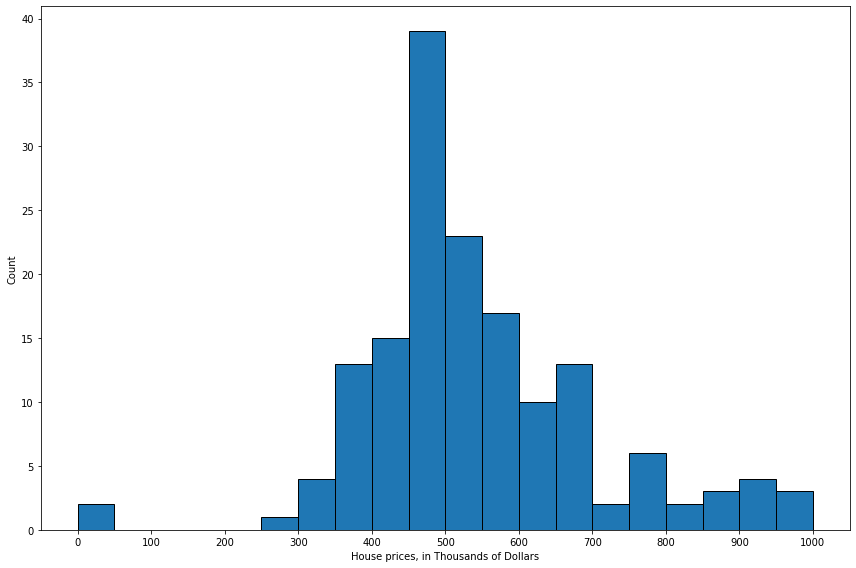

In [148]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(tight_layout=True, figsize=(12,8))
plt.gca().ticklabel_format(style='plain')
plot = axs.hist(df_lowPrice.price / 1000, edgecolor='black', bins=list(range(0, (df_lowPrice.price.max() // 1000) + 50, 50)))
axs.set_xticks(np.arange(0, (max_price + 1) / 1000, 100))
axs.set_xlabel('House prices, in Thousands of Dollars')
axs.set_ylabel('Count')
# plot

[Text(0.5, 0, 'Unit Type'),
 Text(0, 0.5, 'House Prices, in thousands of dollars')]

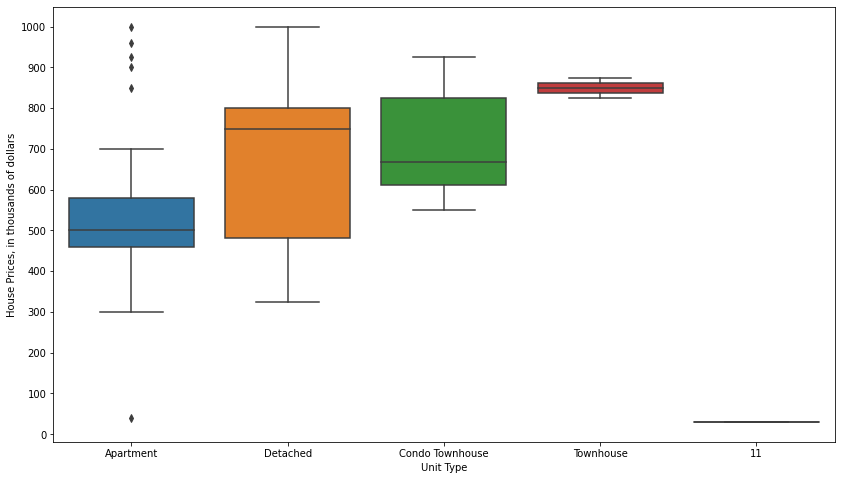

In [147]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(df_lowPrice, x=df_lowPrice.unit_type, y=df_lowPrice.price / 1000)
ax.set_yticks(np.arange(0, (max_price + 1)/1000, 100))
ax.set(xlabel='Unit Type', ylabel='House Prices, in thousands of dollars')

In [138]:
unittype_pivot = pd.pivot_table(df_lowPrice, values='price', index='unit_type', aggfunc=['count', 'mean', 'median'])
unittype_pivot

,count,mean,median
,price,price,price
unit_type,,,
11,1,30000.000000,30000
Apartment,129,522674.108527,499900
Condo Townhouse,7,716657.142857,668800
Detached,18,673054.888889,749950
Townhouse,2,849950.000000,849950


### Filtering Dataframe

In [139]:
# Apply filters here to narrow down search
df1 = df_lowPrice[(df.city == 'Kitchener') & (df_lowPrice.unit_type == 'Detached Single Family')].sort_values('price').head(10)
df1 = df1.reset_index(drop=True)
df1

C:\Users\gilch\AppData\Local\Temp\ipykernel_10124\2673383647.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_lowPrice[(df.city == 'Kitchener') & (df_lowPrice.unit_type == 'Detached Single Family')].sort_values('price').head(10)


,address,unit_type,price,sqft,price_per_sqft,n_beds,n_baths,city,postal_code,days_on_redfin,km_to_Frederic,km_to_Belmont,km_to_Vincenzos,closest_neighbourhood


In [140]:
# Apply filters here to narrow down search
df2 = df_lowPrice[(df_lowPrice.unit_type != 'Apartment') & (df.closest_neighbourhood <= 2)].sort_values('closest_neighbourhood').head(10)
df2 = df2.reset_index(drop=True)
df2

C:\Users\gilch\AppData\Local\Temp\ipykernel_10124\712775691.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df_lowPrice[(df_lowPrice.unit_type != 'Apartment') & (df.closest_neighbourhood <= 2)].sort_values('closest_neighbourhood').head(10)


,address,unit_type,price,sqft,price_per_sqft,n_beds,n_baths,city,postal_code,days_on_redfin,km_to_Frederic,km_to_Belmont,km_to_Vincenzos,closest_neighbourhood
0,56 CEDAR St North,Townhouse,824900,2036.0,405.0,6.0,2.0,Kitchener,N2H 2X1,12.7,0.23,2.93,3.22,0.23
1,78 CHESTNUT St,Detached,799000,1590.0,503.0,5.0,3.0,Kitchener,N2H 1V1,23.8,0.72,3.15,3.25,0.72
2,20 ST GEORGE St Unit 212,Detached,379900,921.0,412.0,2.0,1.0,Kitchener,N2G 2S7,30.7,0.82,2.30,2.67,0.82
3,183 Victoria St N #5,Condo Townhouse,919000,NaN,NaN,4.0,3.0,Kitchener,N2H 5C5,103.7,0.86,2.28,2.42,0.86
4,190 Melrose Ave,Detached,699900,NaN,NaN,3.0,2.0,Kitchener,N2H 2C1,2.8,0.99,3.89,4.07,0.99
5,199 BREITHAUPT St,Detached,799000,3198.0,250.0,4.0,2.5,Kitchener,N2H 5H3,3.3,1.02,2.20,2.30,1.02
6,72 DORSET St,Detached,750000,2058.0,364.0,5.0,5.0,Waterloo,N2L 3M2,3.3,3.99,1.80,1.14,1.14
7,132 Brighton St #15,Condo Townhouse,625000,NaN,NaN,3.0,1.5,Waterloo,N2J 4S5,19.8,3.67,1.96,1.32,1.32
8,87 ELGIN Cres,Detached,899900,1096.0,821.0,4.0,2.0,Waterloo,N2J 2S3,23.6,3.68,2.03,1.39,1.39
9,60 EDINBURGH Rd,Detached,699900,965.0,725.0,4.0,2.0,Kitchener,N2B 1M5,7.1,1.40,4.19,4.30,1.40


In [141]:
df_lowPrice[df_lowPrice.unit_type == 'Townhouse']

,address,unit_type,price,sqft,price_per_sqft,n_beds,n_baths,city,postal_code,days_on_redfin,km_to_Frederic,km_to_Belmont,km_to_Vincenzos,closest_neighbourhood
52,56 CEDAR St North,Townhouse,824900,2036.0,405.0,6.0,2.0,Kitchener,N2H 2X1,12.7,0.23,2.93,3.22,0.23
125,81 SECORD Ave,Townhouse,875000,1000.0,875.0,5.0,2.0,Kitchener,N2B 2L3,53.7,2.86,5.79,5.95,2.86
